# fetch-fonts
This notebook tests converting TTF to vector fonts.

Code source: https://gist.github.com/CatherineH/499a312a04582a00e7559ac0c8f133fa

## download font

In [5]:
!wget https://github.com/adobe-fonts/source-sans/raw/release/TTF/SourceSans3-Regular.ttf

--2023-08-12 20:23:47--  https://github.com/adobe-fonts/source-sans/raw/release/TTF/SourceSans3-Regular.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adobe-fonts/source-sans/release/TTF/SourceSans3-Regular.ttf [following]
--2023-08-12 20:23:48--  https://raw.githubusercontent.com/adobe-fonts/source-sans/release/TTF/SourceSans3-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431196 (421K) [application/octet-stream]
Saving to: ‘SourceSans3-Regular.ttf’

SourceSans3-Regular 100%[===================>] 421.09K  1.06MB/s    in 0.4s    

2023-08-12 20:23:49 (1.06 MB/s) - ‘SourceSans3-

In [6]:
!ls

fetch-fonts.ipynb  SourceSans3-Regular.ttf  Untitled.ipynb


## convert font

In [19]:
import sys

In [ ]:
!sudo apt-get install python3-fontforge

In [21]:
sys.path.append('/usr/lib/python3/dist-packages/')`
import fontforge

In [23]:
def ttf2svg(i, o):
    font = fontforge.open(i)
    font.generate(o)
    font.close()

In [24]:
ttf2svg('SourceSans3-Regular.ttf', 'SourceSans3-Regular.svg')

The following table(s) in the font have been ignored by FontForge
  Ignoring 'DSIG' digital signature table


In [25]:
!ls

fetch-fonts.ipynb	 SourceSans3-Regular.ttf
SourceSans3-Regular.svg  Untitled.ipynb


In [28]:
!head -5 SourceSans3-Regular.svg

<?xml version="1.0" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd" >
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1">
<metadata>
Created by FontForge 20201107 at Tue Apr  4 06:27:06 2023


### wrap the converting, use temp file

In [29]:
import tempfile

In [54]:
import os

In [57]:
from bs4 import BeautifulSoup

In [75]:
def ttf2xml(i: str):
    with tempfile.TemporaryDirectory() as dir:
        font = fontforge.open(i)
        file_address = os.path.join(dir, i + '._generated.svg')
        font.generate(file_address)
        font.close()
        with open(file_address, mode='r') as fp:
            xml_data = fp.read()
            glyphs = BeautifulSoup(xml_data, 'xml').find_all('glyph')

    return glyphs

In [70]:
from collections import namedtuple

In [81]:
Glyph = namedtuple('Glyph', ['d', 'glyph_name', 'unicode'])

In [76]:
xmls = ttf2xml('SourceSans3-Regular.ttf')

The following table(s) in the font have been ignored by FontForge
  Ignoring 'DSIG' digital signature table


In [82]:
def xml2tuple(xml):
    return [
        Glyph(item.get('d'), item.get('glyph_name'), item.get('unicode'))
        for item
        in xml
    ]

In [83]:
glyphs = xml2tuple(xmls)

In [86]:
len(glyphs)

2487

## render fonts

In [87]:
import cairosvg

In [321]:
def fill_into_bb(object_bb: tuple, rect_sizes: tuple):
    '''Calculates translation and scaling for that object with given
    xmax, xmin, ymax, ymin, so that it will be filled and centered inside
    a rectangle with given width and height.
    '''

    src_obj_xmax, src_obj_xmin, src_obj_ymax, src_obj_ymin = object_bb
    im_w, im_h = rect_sizes


    src_obj_w = abs(src_obj_xmax - src_obj_xmin)
    src_obj_h = abs(src_obj_ymax - src_obj_ymin)

    if src_obj_w > src_obj_h:
        scale_x = im_w / src_obj_w
        scale_y = scale_x
        dst_obj_w = src_obj_w * scale_x
        dst_obj_h = src_obj_h * scale_y

    else:
        scale_y = im_h / src_obj_h
        scale_x = scale_y
        dst_obj_w = src_obj_w * scale_x
        dst_obj_h = src_obj_h * scale_y

    translate_x = -src_obj_xmin * scale_x + (im_w - dst_obj_w) / 2
    translate_y = -src_obj_ymin * scale_y + (im_h - dst_obj_h) / 2

    return (
        (round(translate_x, 5), round(translate_y, 5)),
        (round(scale_x, 5), round(scale_y, 5))
    )

In [278]:
def get_svg_boilerplate(
    path: str,
    bounding_box: tuple = None,
    image_w: str = 128, image_h: str = 128,
    background: str = None, fill: str = None
):
    image_size = f'width=\'{image_w}\' height=\'{image_h}\''

    if bounding_box:
        translation, scaling = fill_into_bb(bounding_box, (image_w, image_h))
    else:
        translation, scaling = (0, 0), (1, 1)

    def transform(fname, args):
        args = map(str, args)
        return fname + '(' + ','.join(args) + ')'
    
    return f'''
        <svg
            xmlns='http://www.w3.org/2000/svg'
            xmlns:xlink='http://www.w3.org/1999/xlink'
            {image_size}
            viewPort='0 0 {image_w} {image_h}'
        >
            <rect {image_size} fill='{background or '#fff'}' />
            <path
                d='{path}'
                fill='{fill or '#000'}'
                transform='{transform('translate', translation)} {transform('scale', scaling)}'
            />
        </svg>
    '''

### find bounding box

In [126]:
import svgpathtools

In [135]:
with open('glyph.svg', mode='w+') as fp:
    content = get_svg_boilerplate(glyphs[1000].d, width=0, height=0)
    fp.write(content)

In [136]:
paths, _ = svgpathtools.svg2paths('glyph.svg')

In [225]:
print(str(paths[0])[:200] + '\n[...]')

Path(QuadraticBezier(start=(382-179j), control=(384-99j), end=(385.5-16j)),
     QuadraticBezier(start=(385.5-16j), control=(387+67j), end=(387.5+147j)),
     QuadraticBezier(start=(387.5+147j), contr
[...]


In [216]:
def get_paths_bounding_box(paths):
    for i, path in enumerate(paths):
        if i == 0:
            # Initialise the overall min-max with the first path
            xmin, xmax, ymin, ymax = path.bbox()
        else:
            # Expand bounds to match path bounds if needed
            p_xmin, p_xmax, p_ymin, p_ymax = path.bbox()
            xmin = p_xmin if p_xmin < xmin else xmin
            xmax = p_xmax if p_xmax > xmax else xmax
            ymin = p_ymin if p_ymin < ymin else ymin
            ymax = p_ymax if p_ymax > ymax else ymax

    return xmax, xmin, ymax, ymin

Wrap it up:

In [232]:
def get_glyph_bb(path: str, fname: str) -> tuple:

    with open(fname, mode='w+') as f_glyph:
        content = get_svg_boiзкlerplate(path)
        f_glyph.write(content)

    paths, _ = svgpathtools.svg2paths(fname)

    return get_paths_bounding_box(paths)

In [290]:
def render_png(path: str, svg_text, image_w, image_h, fname: str):
    png_data = cairosvg.svg2png(
        bytestring=svg_text.encode(),
        output_width=image_w,
        output_height=image_h
    )
    with open(fname, mode='wb+') as fp:
        fp.write(png_data)

In [336]:
def glyph2array(glyph: Glyph, image_w: int = 128, image_h: int = 128):
    
    with tempfile.TemporaryDirectory() as dir:
        glyph_fname = os.path.join(dir, (glyph.unicode or '?').encode().hex())
        bounding_box = get_glyph_bb(glyph.d, glyph_fname + '.svg')
        svg_text = get_svg_boilerplate(glyph.d, bounding_box)
        render_png(glyph.d, svg_text, image_w, image_h, glyph_fname + '.png')

        return plt.imread(glyph_fname + '.png')

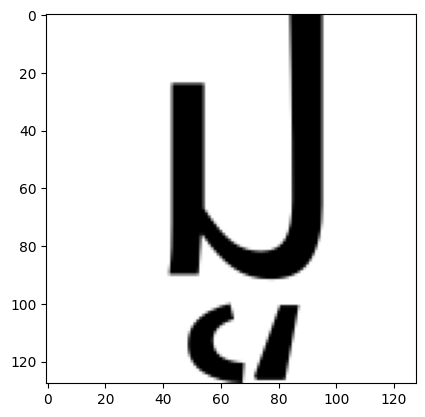

In [324]:
plt.imshow(glyph2array(glyphs[1001]))

In [334]:
glyphs[100]

Glyph(d='M90 0v656h164q152 0 231 -84.5t79 -240.5q0 -157 -78.5 -244t-227.5 -87h-168zM173 68h75q115 0 172.5 69.5t57.5 193.5t-57.5 190.5t-172.5 66.5h-75v-520zM301 -206q-24 0 -39.5 14.5t-15.5 39.5q0 24 15.5 39t39.5 15t39.5 -15t15.5 -39q0 -25 -15.5 -39.5 t-39.5 -14.5z', glyph_name=None, unicode='Ḍ')

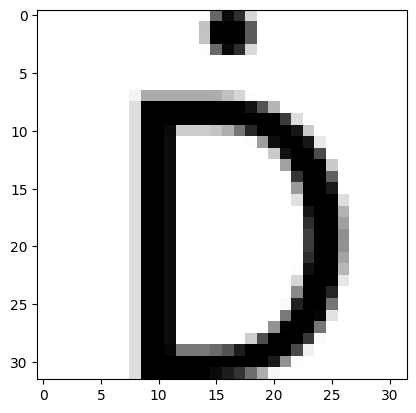

In [341]:
plt.imshow(glyph2array(glyphs[100], image_w=32, image_h=32))